In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama

In [3]:
# download dataset and extract it
! export KAGGLE_USERNAME="khairulsyah" && export KAGGLE_KEY="9438d0d4c9356851c8751a925f3beaed" && kaggle datasets download --unzip solothok/cat-breed
! ls

 82% 73.0M/89.0M [00:00<00:00, 135MB/s] 
100% 89.0M/89.0M [00:00<00:00, 114MB/s]
cat-breed  drive  sample_data


In [4]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd cat-breed/TEST && ls

/content
cat-breed  drive  sample_data

Folders(classess) in training folder: ...
americanshorthair  bengal  mainecoon  ragdoll  scottishfold  sphinx


In [5]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

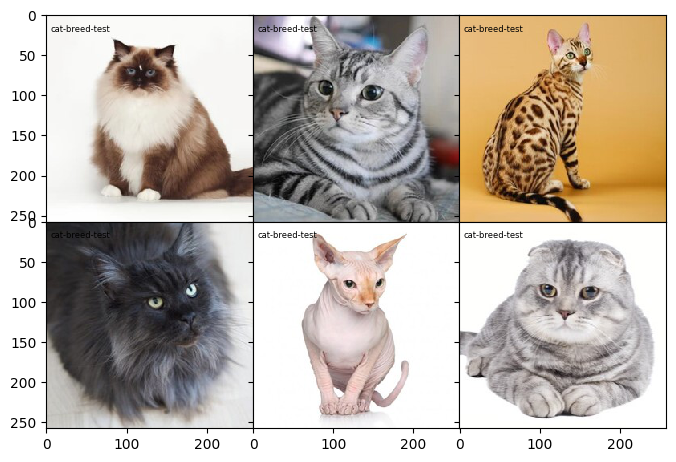

In [7]:
import glob
import os
from mpl_toolkits.axes_grid1 import ImageGrid

ASL = np.array([file for file in glob.glob('cat-breed/cat-breed-test/*') if os.path.isfile(file)])

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0,  # pad between axes in inch.
                 )
l = 0
for img in ASL:
    im = plt.imread(img)
    grid[l].imshow(im, cmap='gray', interpolation='nearest')
    grid[l].text(5, 20, img.split('/')[1].split('_')[0], fontsize=6)
    l += 1


In [8]:
#creating the dataloaders

# Define transforms for the training data and testing data
train_path='cat-breed/TRAIN'
valid_path='cat-breed/TEST'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [49]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
#dibagian ini perlu diubah CPU nya
print("Device used: CPU")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")


Device used: CPU
class to index mapping: {'americanshorthair': 0, 'bengal': 1, 'mainecoon': 2, 'ragdoll': 3, 'scottishfold': 4, 'sphinx': 5}


In [10]:
# choose a pretrained model to start with check options here: https://pytorch.org/vision/stable/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network
for param in model.parameters():
    param.requires_grad = False

#print the model to check the classifer and change it
print (model.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [11]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True


# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)


Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


image number 40
---------------------
label: americanshorthair
prediction: americanshorthair


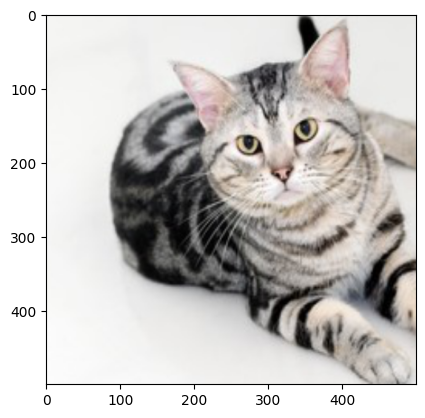

In [45]:
### try your model on some images
%matplotlib inline

#dibagian ini perlu diubah CPU nya
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data
from torchvision import transforms

resize_transform = transforms.RandomResizedCrop((500, 500))
test_data_t = datasets.ImageFolder(valid_path, transforms.Compose([resize_transform, transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=200, shuffle=True)
images_t, labels_t = next(iter(testloader_t))



#Choose arandom image from 0 to 199
index = np.random.randint(0, 50)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img = t_n(test_img).unsqueeze(0).cpu()


#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

# Tambahkan kunci yang hilang ke dictionary classes


# Print predicted class
print("prediction:", classes[res.argmax().item()])


In [47]:
#Define number of epochs through data and run the training loop
import math

#dibagian ini perlu diubah CPU nya
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 20
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [50]:
%%time
from tqdm import tqdm
from colorama import Fore,Style
import sys

for epoch in range(epochs):
    print(Style.RESET_ALL)
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in tqdm(trainloader,desc=Fore.GREEN +f"* PROGRESS IN EPOCH {epoch+1} ",file=sys.stdout):
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()




            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0


    scheduler.step()
    step=0



--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  3 of 3) ... Train loss: 0.308 ... Test loss: 1.804 ... Test accuracy: 0.693 
* PROGRESS IN EPOCH 1 : 100%|██████████| 3/3 [03:23<00:00, 67.78s/it]

--------------------------------- START OF EPOCH [ 2 ] >>> LR =  5e-05 ---------------------------------

Epoch (2 of 2) ... Step  (  3 of 3) ... Train loss: 0.278 ... Test loss: 0.658 ... Test accuracy: 0.840 
* PROGRESS IN EPOCH 2 : 100%|██████████| 3/3 [03:02<00:00, 60.67s/it]
CPU times: user 3min 38s, sys: 2min 26s, total: 6min 4s
Wall time: 6min 25s


In [53]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data
resize_transform = transforms.Resize((280, 280))
test_data = datasets.ImageFolder(valid_path, transforms.Compose([resize_transform, transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)
images, labels = next(iter(testloader))


image number 33
---------------------
label: americanshorthair
prediction: americanshorthair


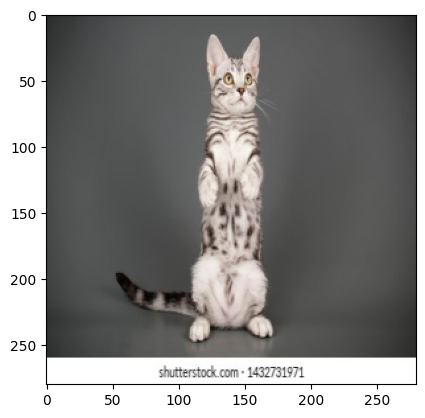

In [77]:
#Choose arandom image from 0 to 50
index = np.random.randint(0, 50)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#dibagian ini perlu diubah CPU nya
#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).to('cpu')

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

